# Deep learning fundamental A1 - Predict diabetes using Perceptron

## 1. Load and display the dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def load_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Extract labels and features
    labels = []
    features = []
    
    # convert target value -1 and +1 to 0 and 1
    for line in lines:
        items = line.strip().split()
        
        if items[0] == '+1':
            label = 1
        elif items[0] == '-1':
            label = 0
            
        label_list = [label]
        
        feature_dict = {}
        for item in items[1:]:
            index, value = item.split(':')
            feature_dict[int(index)] = float(value)
        
        features.append(feature_dict)
        labels.append(label_list)
    
    # Convert feature dictionaries to DataFrame
    feature_df = pd.DataFrame(features)
    
    # Combine features and labels
    label_df = pd.DataFrame(labels, columns=['Outcome'])
    df = pd.concat([label_df, feature_df], axis=1)
    
    return df

file_path = 'diabetes.txt'
df = load_data(file_path)

# Rename columns for better visualisation
df.columns = ['Outcome', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 
              'DiabetesPedigreeFunction', 'Age']

# Check missing values and dataset distribution
print("Dataset Info:")
print("Outcome distribution:")
print(df['Outcome'].value_counts())
df.info()  # View dataset structure, data types, and missing values
# There is no missing date.

print("Dataset distribution:")
print(df.describe())  # Check for dataset distribution
# There are some outliers but seems no error, so no need data cleaning.
# As there are some outliers, I will use robust scaling for preprocessing.

# Separate features and target
X = df.drop(columns=['Outcome'])
y = df['Outcome']

Dataset Info:
Outcome distribution:
1    500
0    268
Name: Outcome, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Outcome                   768 non-null    int64  
 1   Pregnancies               768 non-null    float64
 2   Glucose                   768 non-null    float64
 3   BloodPressure             768 non-null    float64
 4   SkinThickness             768 non-null    float64
 5   Insulin                   768 non-null    float64
 6   BMI                       768 non-null    float64
 7   DiabetesPedigreeFunction  768 non-null    float64
 8   Age                       768 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 54.1 KB
Dataset distribution:
          Outcome  Pregnancies     Glucose  BloodPressure  SkinThickness  \
count  768.000000   768.000000  768.000000     768.000000   

## 2. Split and preprocess the dataset

In [2]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a pipeline for scaling and potential future preprocessing steps
pipeline = Pipeline([
    ('scaler', RobustScaler())
])

# Apply the pipeline on training and test data
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)  
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# define a cross-validation for baseline model and hyperparameter optimisation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## 3.  Select model and implement a baseline model

In [3]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Define a single layer perceptron model
class Perceptron(nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1)  # Single layer

    def forward(self, x):
        return torch.sigmoid(self.fc(x))  # Using sigmoid activation for binary classification
    
# Define a function to train and evaluate a model
def train_and_evaluate(model, criterion, optimizer, X_train, y_train, X_val, y_val):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val).squeeze()
        predictions = (val_outputs >= 0.5).float()
        
        val_loss = criterion(val_outputs, y_val)
        
        # Convert tensors to numpy arrays for metric calculations
        y_val_np = y_val.numpy()
        predictions_np = predictions.numpy()
        val_outputs_np = val_outputs.numpy()
        
        accuracy = accuracy_score(y_val_np, predictions_np)
        precision = precision_score(y_val_np, predictions_np)
        recall = recall_score(y_val_np, predictions_np)
        f1 = f1_score(y_val_np, predictions_np)
    
    return val_loss.item(), accuracy, precision, recall, f1

# Define a function to train baseline model using cross-validation
def train_and_evaluate_baseline(X_train, y_train, num_epochs, lr):
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    
    for train_index, val_index in kf.split(X_train):
        train_fold_data, val_fold_data = X_train[train_index], X_train[val_index]
        train_fold_labels, val_fold_labels = y_train[train_index], y_train[val_index]

        model = Perceptron(input_size=X_train.shape[1])
        criterion = nn.BCELoss()
        optimizer = optim.SGD(model.parameters(), lr=lr)

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(train_fold_data).squeeze()
            loss = criterion(outputs, train_fold_labels)
            loss.backward()
            optimizer.step()

        val_loss, accuracy, precision, recall, f1 = train_and_evaluate(
            model, criterion, optimizer, train_fold_data, train_fold_labels, val_fold_data, val_fold_labels
        )
        
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
    
    avg_metrics = {metric: np.mean(values) for metric, values in fold_metrics.items()}
    return avg_metrics

# Train and evaluate the baseline model with default hyperparameters
baseline_metrics = train_and_evaluate_baseline(X_train, y_train, num_epochs=50, lr=0.01)
print("\nBaseline Model Cross-Validation Results:")
print(f"Accuracy: {baseline_metrics['accuracy'] * 100:.2f}%, Precision: {baseline_metrics['precision'] * 100:.2f}%, Recall: {baseline_metrics['recall'] * 100:.2f}%, F1 Score: {baseline_metrics['f1'] * 100:.2f}%")
print("\n")


Baseline Model Cross-Validation Results:
Accuracy: 54.88%, Precision: 66.21%, Recall: 68.14%, F1 Score: 65.44%




## 4. Hyperparameter optimisation

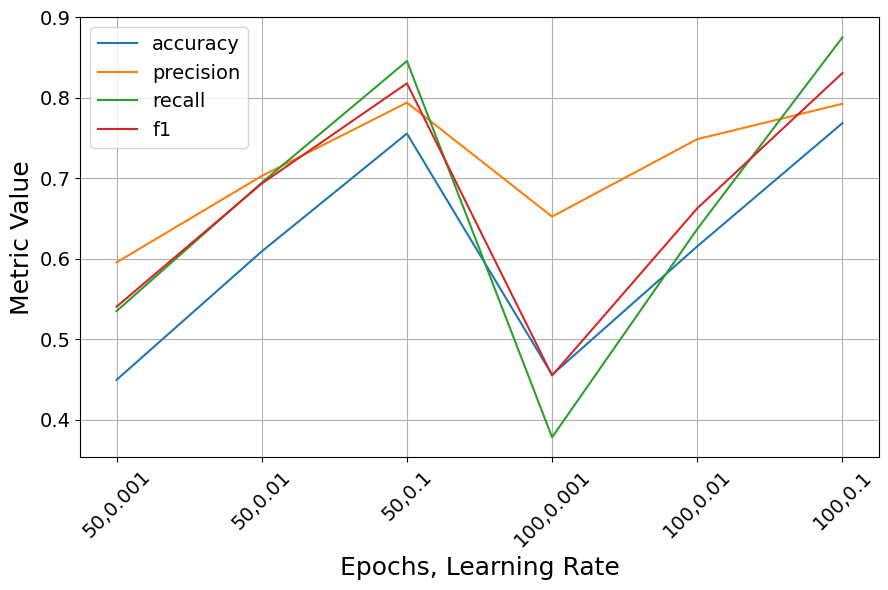

Best Hyperparameters: {'epochs': 100, 'lr': 0.1}

Hyperparameter Tuning Results:
Epochs: 50, Learning Rate: 0.001, Accuracy: 0.45, Precision: 0.60, Recall: 0.53, F1 Score: 0.54
Epochs: 50, Learning Rate: 0.01, Accuracy: 0.61, Precision: 0.70, Recall: 0.69, F1 Score: 0.69
Epochs: 50, Learning Rate: 0.1, Accuracy: 0.76, Precision: 0.79, Recall: 0.85, F1 Score: 0.82
Epochs: 100, Learning Rate: 0.001, Accuracy: 0.46, Precision: 0.65, Recall: 0.38, F1 Score: 0.45
Epochs: 100, Learning Rate: 0.01, Accuracy: 0.62, Precision: 0.75, Recall: 0.64, F1 Score: 0.66
Epochs: 100, Learning Rate: 0.1, Accuracy: 0.77, Precision: 0.79, Recall: 0.88, F1 Score: 0.83


In [4]:
import matplotlib.pyplot as plt

# Set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Define a function to tune hyperparameters and plot results
def tune_hyperparameters_and_plot(X_train, y_train, num_epochs_list, learning_rates):
    results = []
    best_metrics = {'accuracy': 0}
    best_params = {'epochs': 0, 'lr': 0}
    
    for num_epochs in num_epochs_list:
        for lr in learning_rates:
            metrics = train_and_evaluate_baseline(X_train, y_train, num_epochs, lr)
            results.append({'epochs': num_epochs, 'lr': lr, **metrics})
            
            if metrics['accuracy'] > best_metrics['accuracy']:
                best_metrics = metrics
                best_params = {'epochs': num_epochs, 'lr': lr}

    # Prepare for plotting
    metrics_labels = ['accuracy', 'precision', 'recall', 'f1']
    plt.figure(figsize=(9, 6))
    
    for metric in metrics_labels:
        values = [result[metric] for result in results]
        plt.plot([f"{result['epochs']},{result['lr']}" for result in results], values, label=metric)

    # plt.title('Hyperparameter Tuning Results', fontsize=20)
    plt.xlabel('Epochs, Learning Rate', fontsize=18)
    plt.ylabel('Metric Value', fontsize=18)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14) 
    plt.legend(fontsize=14)
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    return best_params, results

# Define hyperparameter options
num_epochs_list = [50, 100]  # Number of epochs to test
learning_rates = [0.001, 0.01, 0.1]  # Learning rates to test

# Perform hyperparameter tuning and plot results
best_params, tuning_results = tune_hyperparameters_and_plot(X_train, y_train, num_epochs_list, learning_rates)
print(f'Best Hyperparameters: {best_params}')

# Print tuning results for each hyperparameter combination
print("\nHyperparameter Tuning Results:")
for result in tuning_results:
    print(f"Epochs: {result['epochs']}, Learning Rate: {result['lr']}, "
          f"Accuracy: {result['accuracy']:.2f}, Precision: {result['precision']:.2f}, "
          f"Recall: {result['recall']:.2f}, F1 Score: {result['f1']:.2f}")

## 5. Train and evaluate the best model

In [5]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Train the model with the best hyperparameters on the full training data
model = Perceptron(input_size=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=best_params['lr'])

# Train the best model
for epoch in range(best_params['epochs']):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

# Evaluate the model with the best hyperparameters on the test set
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test).squeeze()
        predictions = (outputs >= 0.5).float() # Convert probabilities to binary predictions
        
        y_test_np = y_test.numpy()
        predictions_np = predictions.numpy()
        outputs_np = outputs.numpy()
        
        accuracy = accuracy_score(y_test_np, predictions_np)
        precision = precision_score(y_test_np, predictions_np)
        recall = recall_score(y_test_np, predictions_np)
        f1 = f1_score(y_test_np, predictions_np)
        auc = roc_auc_score(y_test_np, outputs_np)
        
        print(f'Accuracy: {accuracy * 100:.2f}%')
        print(f'Precision: {precision * 100:.2f}%')
        print(f'Recall: {recall * 100:.2f}%')
        print(f'F1 Score: {f1 * 100:.2f}%')

# Evaluate the best model
print("\nThe Best Model Results on test set:")
evaluate(model, X_test, y_test)


The Best Model Results on test set:
Accuracy: 74.68%
Precision: 76.52%
Recall: 88.00%
F1 Score: 81.86%
